In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kkbox-music-recommendation-challenge/test.csv.7z
/kaggle/input/kkbox-music-recommendation-challenge/train.csv.7z
/kaggle/input/kkbox-music-recommendation-challenge/songs.csv.7z
/kaggle/input/kkbox-music-recommendation-challenge/members.csv.7z
/kaggle/input/kkbox-music-recommendation-challenge/song_extra_info.csv.7z
/kaggle/input/kkbox-music-recommendation-challenge/sample_submission.csv.7z


In [2]:
os.system('apt-get install p7zip')

Reading package lists...
Building dependency tree...
Reading state information...
Suggested packages:
  p7zip-full
The following NEW packages will be installed:
  p7zip
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 358 kB of archives.
After this operation, 996 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip amd64 16.02+dfsg-6 [358 kB]


debconf: delaying package configuration, since apt-utils is not installed


Fetched 358 kB in 0s (1818 kB/s)
Selecting previously unselected package p7zip.
(Reading database ... 109092 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-6_amd64.deb ...
Unpacking p7zip (16.02+dfsg-6) ...
Setting up p7zip (16.02+dfsg-6) ...


0

In [3]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 77 kB 659 kB/s 


In [4]:
from pyunpack.cli import Archive

directory = '/kaggle/working/'
Archive('/kaggle/input/kkbox-music-recommendation-challenge/train.csv.7z').extractall(directory)
Archive('/kaggle/input/kkbox-music-recommendation-challenge/test.csv.7z').extractall(directory)
Archive('/kaggle/input/kkbox-music-recommendation-challenge/songs.csv.7z').extractall(directory)
Archive('/kaggle/input/kkbox-music-recommendation-challenge/members.csv.7z').extractall(directory)
Archive('/kaggle/input/kkbox-music-recommendation-challenge/song_extra_info.csv.7z').extractall(directory)

train = pd.read_csv('/kaggle/working/train.csv')
test = pd.read_csv('/kaggle/working/test.csv')
songs = pd.read_csv('./songs.csv')
members = pd.read_csv('./members.csv') 
songs_extra = pd.read_csv('./song_extra_info.csv')

In [5]:
train = pd.read_csv('/kaggle/working/train.csv')
test = pd.read_csv('/kaggle/working/test.csv')
songs = pd.read_csv('./songs.csv', index_col='song_id')
members = pd.read_csv('./members.csv', index_col='msno') 
songs_extra = pd.read_csv('./song_extra_info.csv', index_col='song_id')

## Preprocess songs and members information

Derive years on decades 

In [6]:
songs_extra['year'] = songs_extra['isrc'].str[5:7]
songs_extra['year'] = songs_extra['year'].fillna(-1).apply(int)
songs_extra['year'] = np.where(((songs_extra['year'] > 0) & (songs_extra['year'] > 17)), songs_extra['year'] + 1900, songs_extra['year'] + 2000)
songs_extra['decade'] = songs_extra['year'] // 10 * 10
songs_extra['country'] = songs_extra['isrc'].str[:2]

Percent of nan data in songs dataset

In [7]:
def nan_percent(df):
    return df.isna().sum() * 100 /df.shape[0]

In [8]:
nan_percent(songs)

song_length     0.000000
genre_ids       4.098558
artist_name     0.000000
composer       46.655257
lyricist       84.712409
language        0.000044
dtype: float64

Let's fill genre and langeagu NaNs as most popular genres for the specific artist. Other values as UNKNOWN

In [9]:
songs['genre_list'] = songs['genre_ids'].str.split('|')
df_most_common = songs[['genre_list', 'language', 'artist_name']].groupby('artist_name').agg(pd.Series.mode)
df_most_common = df_most_common[~df_most_common.index.duplicated(keep='first')].reset_index()
df_most_common.columns = ['artist_name','genre_pop', 'language_pop']

In [10]:
songs_pop = songs.reset_index().merge(df_most_common, how='left', on='artist_name')
songs_pop['genre_list'] = songs_pop['genre_list'].fillna(songs_pop['genre_pop']) 
songs_pop['language'] = songs_pop['language'].fillna(songs_pop['language_pop'])
songs_pop = songs_pop.fillna('UNKNOWN')
songs = songs_pop.set_index('song_id')[['song_length', 'artist_name', 'composer', 'lyricist', 'language','genre_ids', 'genre_list']]

Let's look on dictibution of song length in train data

<AxesSubplot:>

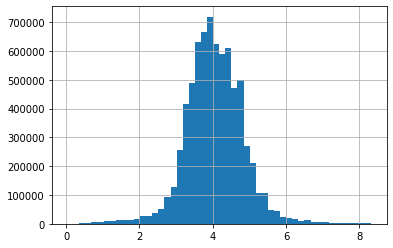

In [11]:
train_song = train.set_index('song_id').join(songs)
(train_song.loc[train_song.song_length < 500000]['song_length'] / 60000).hist(bins=50)

The usual song length are in interval [2.5, 5.5] minutes.

The other right side of the data on histogram is just decreasing tail. So, let's just random divide song length on following intervals:

0. [0, 2.5]
1. [2.5, 5.5]
2. [5.5, 10]
3. [10, 30]
4. [30, 60]
5. \>60 
minutes

<AxesSubplot:>

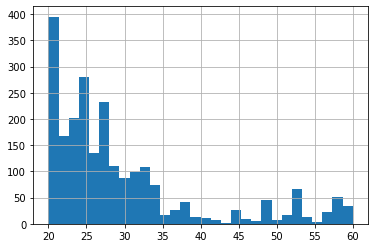

In [12]:
(train_song.loc[(train_song.song_length > 20 * 60000) & (train_song.song_length < 60 * 60000)]['song_length'] / 60000).hist(bins=30)

In [13]:
condlist = [songs['song_length'] < 2.5*60000,
            (songs['song_length']>=2.5*60000) & (songs['song_length'] < 5.5 * 60000), 
            (songs['song_length'] >= 5.5 * 60000) & (songs['song_length'] < 10 * 60000),
            (songs['song_length'] >= 10 * 60000) & (songs['song_length'] < 30 * 60000), 
            (songs['song_length'] >= 30 * 60000) & (songs['song_length'] < 60 * 60000),
            songs['song_length'] >= 60 * 60000]
choicelist = list(range(0, len(condlist)))
songs['song_length_cat'] = np.select(condlist, choicelist)

In [14]:
artists_num = songs.artist_name.str.split('|')
len_artists_num = [len(x) for x in list(artists_num) if len(x) != 1 and len(x) <50]

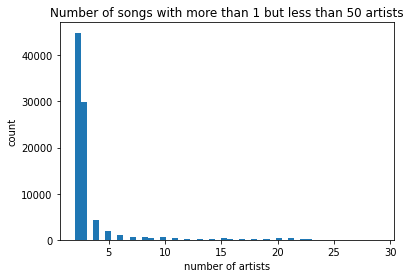

In [15]:
from matplotlib import pyplot as plt

data = len_artists_num

plt.hist(data, bins=50)
plt.title('Number of songs with more than 1 but less than 50 artists')
plt.xlabel('number of artists')
plt.ylabel('count')

plt.show()

In [16]:
def count_series_elements(df, column_name):
    df[column_name+'_number'] = df[column_name].str.count(r'\|') + 1
    df.loc[df[column_name] == 'UNKNOWN', column_name+'_number'] = 0

In [17]:
count_series_elements(songs, 'artist_name')
count_series_elements(songs, 'composer')
count_series_elements(songs, 'lyricist')
songs['genre_number'] = songs['genre_list'].str.len()

In [18]:
nan_percent(songs_extra)

name       0.000087
isrc       5.947288
year       0.000000
decade     0.000000
country    5.947288
dtype: float64

In [19]:
songs_all = songs.join(songs_extra)

In [20]:
nan_percent(songs_all)

song_length           0.000000
artist_name           0.000000
composer              0.000000
lyricist              0.000000
language              0.000000
genre_ids             0.000000
genre_list            0.000000
song_length_cat       0.000000
artist_name_number    0.000000
composer_number       0.000000
lyricist_number       0.000000
genre_number          0.000000
name                  0.039193
isrc                  5.984706
year                  0.039106
decade                0.039106
country               5.984706
dtype: float64

Let's get rid of nan values in "decade" and "country" by choosing the most common decades and countries in artist's name

In [21]:
df_most_common = songs_all[['decade', 'country', 'artist_name']].groupby('artist_name').agg(pd.Series.mode)
df_most_common = df_most_common[~df_most_common.index.duplicated(keep='first')].reset_index()
df_most_common.columns = ['artist_name','decade_pop', 'country_pop']

In [22]:
songs_pop = songs_all.reset_index().merge(df_most_common, how='left', on='artist_name')
songs_pop['decade'] = songs_pop['decade'].fillna(songs_pop['decade_pop']) 
songs_pop['country'] = songs_pop['country'].fillna(songs_pop['country_pop'])
songs_pop = songs_pop.fillna('UNKNOWN')

In [23]:
songs_all = songs_pop.set_index('song_id')[['song_length', 'artist_name','composer', 'lyricist', 'language', 'genre_list', 
                                            'song_length_cat', 'artist_name_number', 'composer_number', 'lyricist_number', 
                                            'genre_number', 'name', 'decade', 'country']]

### Final songs data

In [24]:
songs_all

,song_length,artist_name,composer,lyricist,language,genre_list,song_length_cat,artist_name_number,composer_number,lyricist_number,genre_number,name,decade,country
song_id,,,,,,,,,,,,,,
CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,張信哲 (Jeff Chang),董貞,何啟弘,3.0,[465],1,1,1,1,1,焚情,2010.0,TW
o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,[444],1,1,3,1,1,PLAYING WITH FIRE,1990.0,TW
DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,SUPER JUNIOR,UNKNOWN,UNKNOWN,31.0,[465],1,1,0,0,1,SORRY| SORRY,1990.0,KR
dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,S.H.E,湯小康,徐世珍,3.0,[465],1,1,1,1,1,愛我的資格,2000.0,TW
W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,貴族精選,Traditional,Traditional,52.0,[726],0,1,1,1,1,Mary Had a Little Lamb,1990.0,GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,20192,Catherine Collard,Robert Schumann (1810-1856),UNKNOWN,-1.0,[958],0,1,1,0,1,Schumann: Papillons| Op. 2: II. Prestissimo,1970.0,FR
nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,273391,紀文惠 (Justine Chi),UNKNOWN,UNKNOWN,3.0,[465],1,1,0,0,1,怎麼啦,2010.0,TW
9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,445172,Various Artists,UNKNOWN,UNKNOWN,52.0,[1609],2,1,0,0,1,Still Here,2010.0,DE


In [25]:
nan_percent(songs_all)

song_length           0.0
artist_name           0.0
composer              0.0
lyricist              0.0
language              0.0
genre_list            0.0
song_length_cat       0.0
artist_name_number    0.0
composer_number       0.0
lyricist_number       0.0
genre_number          0.0
name                  0.0
decade                0.0
country               0.0
dtype: float64